In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hamiltonian_gas import HamiltonianGasSystem

In [2]:
dimension: int = 2
num_particles: int = 5
box_size: float = 1.
half_box_size: float = box_size/2

In [3]:
coordinates = (np.random.rand(num_particles, dimension)-half_box_size)*2
momentums = np.random.normal(0, 1, (num_particles, dimension))
coordinates, momentums

(array([[ 0.06457735,  0.02142381],
        [ 0.88376128,  0.81695723],
        [-0.87409762, -0.58389759],
        [-0.05571639, -0.88295421],
        [-0.4116228 ,  0.31307372]]),
 array([[ 0.29363004,  0.77412811],
        [-0.05772709,  0.2299457 ],
        [ 0.39577617, -0.26564613],
        [-0.55089029,  1.72338617],
        [-0.21697543,  1.24625246]]))

In [4]:
gas = HamiltonianGasSystem(1, 1, 0.01, 0.1)
gas.energy(coordinates, momentums)

5.225547428509381

In [6]:
gas.d_interaction(coordinates)

array([[-1.03846882e-04,  3.54608502e-05],
       [-1.92751300e-05, -1.55446282e-05],
       [ 5.07559218e-05,  1.57946331e-05],
       [-2.65411268e-05,  4.87382574e-05],
       [ 9.89072169e-05, -8.44491125e-05]])

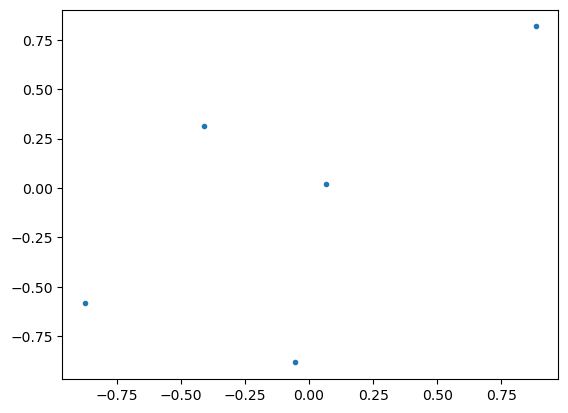

In [12]:
plt.scatter(*coordinates.T, marker='.')